<a href="https://colab.research.google.com/github/sydney-machine-learning/cyclonegenesis_seasurfacetemperature/blob/albert/Bayesian_Regression_WIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [2]:
import os
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive





In [3]:
DATASET_URL = "https://raw.githubusercontent.com/sydney-machine-learning/cyclonegenesis_seasurfacetemperature/albert/Climate%20Project/albert/cyclone_data/jtwc/cleaned/full_cleaned.csv"
dset = pd.read_csv(DATASET_URL)
# rename columns
dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
dset

/var/folders/x5/vcqjj1kn44sfdfx9zvjr5t3m0000gp/T/ipykernel_51369/199107379.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()
/var/folders/x5/vcqjj1kn44sfdfx9zvjr5t3m0000gp/T/ipykernel_51369/199107379.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dset.columns = dset.columns.str.replace(' ', '_').str.replace('(','').str.replace(')','').str.lower()


,unnamed:_0,timestamp,storm_id,basin,season,season_tc_number,stormname,latitude_degrees,longitude_degrees,vmax_kt,peak_vmax_kt,ace,maximum_24h_intensification,tropical_sst,local_sst,local_month_mean
0,921,1982-08-04 12:00:00,1982-N-12,WP,1982.0,12.0,NaN,19.8,130.9,20.0,125.0,2.14875,45.0,27.565964,28.316607,29.196020
1,922,1982-08-08 00:00:00,1982-N-13,WP,1982.0,13.0,NaN,7.7,153.9,20.0,80.0,0.86525,25.0,27.565964,28.282774,29.311720
2,923,1982-08-17 06:00:00,1982-N-14,WP,1982.0,14.0,NaN,8.2,154.2,20.0,125.0,2.72850,25.0,27.565964,28.308462,29.301773
3,924,1982-08-20 00:00:00,1982-N-15,WP,1982.0,15.0,NaN,11.3,124.8,20.0,90.0,1.47000,35.0,27.565964,28.343359,29.167967
4,925,1982-08-27 00:00:00,1982-N-16,WP,1982.0,16.0,NaN,14.6,153.8,30.0,100.0,2.33900,30.0,27.565964,28.092667,29.231500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,1877,2022-10-14 06:00:00,2022-N-24,WP,2022.0,24.0,INVEST,26.4,154.4,25.0,40.0,0.19675,15.0,27.681841,28.137896,27.757618
1780,1878,2022-10-26 00:00:00,2022-N-26,WP,2022.0,26.0,INVEST,12.2,133.8,20.0,75.0,0.67825,25.0,27.681841,29.645842,29.207080
1781,1879,2022-10-28 12:00:00,2022-N-27,WP,2022.0,27.0,INVEST,8.0,140.4,25.0,40.0,0.10875,15.0,27.681841,29.821840,29.312254
1782,1880,2022-11-11 18:00:00,2022-N-28,WP,2022.0,28.0,INVEST,20.2,166.3,20.0,40.0,0.10600,10.0,27.664591,28.148760,27.703903


In [4]:
standardize = lambda x: (x - x.mean()) / x.std()

## FOR NUMERICAL STABILITY
dset["tropical_sst_scaled"] = dset.tropical_sst.pipe(standardize)
dset["local_sst_scaled"] = dset.local_sst.pipe(standardize)
dset["peak_wind_scaled"] = dset.peak_vmax_kt.pipe(lambda x: standardize(x + dset['local_sst_scaled']))

In [5]:
def model(tropical_sst=None, local_sst=None, peak_wind=None, q=None):
    if q is None:
      q = 0.5

    intercept = numpyro.sample("intercept", dist.ImproperUniform(dist.constraints.real, (), event_shape=()))

    TROPICAL_COMPONENT = 0.0
    LOCAL_COMPONENT = 0.0

    if tropical_sst is not None:
        tropical_coef = numpyro.sample("tropical_coef", dist.ImproperUniform(dist.constraints.real, (), event_shape=()))
        TROPICAL_COMPONENT = tropical_coef * tropical_sst

    if local_sst is not None:
        local_coef = numpyro.sample("local_coef", dist.ImproperUniform(dist.constraints.real, (), event_shape=()))
        LOCAL_COMPONENT = local_coef * local_sst

    # use a uniform prior instead??
    mu = intercept + TROPICAL_COMPONENT + LOCAL_COMPONENT
    numpyro.deterministic("mu", mu)

   # THIS IS WHERE THE QUANTILE REGRESSION COMES IN
    obs = numpyro.sample('obs', dist.AsymmetricLaplaceQuantile(loc=mu, scale=1.0,quantile=q), obs=peak_wind)

In [6]:
rng_key = random.PRNGKey(0)

qs = [0.10, 0.25, 0.5, 0.75, 0.85, 0.9, 0.92, 0.95, 0.98]
qs = [0.10, 0.5, 0.75, 0.95, 0.98]
params = {}

for q in qs:
    rng_key, rng_key_ = random.split(rng_key)
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_chains=4, num_warmup=500, num_samples=500, progress_bar=True)
    mcmc.run(
        rng_key_,
        tropical_sst=dset.tropical_sst_scaled.values,
        local_sst=dset.local_sst_scaled.values,
        peak_wind=dset.peak_wind_scaled.values,
        q=q )
    mcmc_samples = mcmc.get_samples()

    posterior_predictive = Predictive(
        model, posterior_samples=mcmc_samples, 
        # return_sites=extract_vars
    )(rng_key,
      tropical_sst=dset.tropical_sst_scaled.values,
      local_sst=dset.local_sst_scaled.values,
      peak_wind=dset.peak_wind_scaled.values,
      q=q
    )
    arviz_posterior = az.from_numpyro(
            mcmc,
            posterior_predictive=posterior_predictive,
            # coords=az_coords,
            # dims=az_dims
    )
    params[q] = arviz_posterior
    print(q)
    mcmc.print_summary()
    print()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.1

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -1.16      0.03     -1.16     -1.21     -1.12   1218.54      1.00
     local_coef      0.05      0.03      0.04      0.01      0.10   1301.75      1.00
  tropical_coef     -0.02      0.03     -0.02     -0.07      0.03   1243.50      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.5

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept     -0.19      0.04     -0.19     -0.27     -0.12   1663.48      1.00
     local_coef      0.19      0.05      0.20      0.12      0.27   1457.89      1.00
  tropical_coef     -0.02      0.05     -0.02     -0.10      0.05   1661.72      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.75

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      0.85      0.05      0.85      0.77      0.93   1731.64      1.00
     local_coef      0.17      0.06      0.18      0.08      0.27   1085.87      1.01
  tropical_coef      0.09      0.05      0.09      0.00      0.17   1353.93      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.95

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      1.71      0.05      1.71      1.62      1.79   1863.51      1.00
     local_coef      0.18      0.07      0.18      0.07      0.29   1525.54      1.00
  tropical_coef      0.06      0.06      0.06     -0.05      0.16   1300.11      1.00

Number of divergences: 0



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.98

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
      intercept      1.97      0.09      1.96      1.80      2.10   1262.41      1.00
     local_coef      0.18      0.10      0.18      0.01      0.33    950.76      1.00
  tropical_coef      0.06      0.09      0.06     -0.07      0.22   1125.55      1.00

Number of divergences: 0



In [7]:
arviz_posterior

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
sample = params[q]
sample.posterior_predictive['mu'].mean(dim=['chain','draw']).values

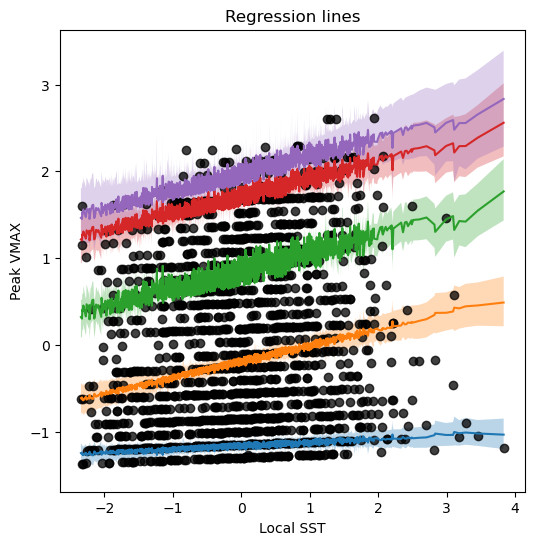

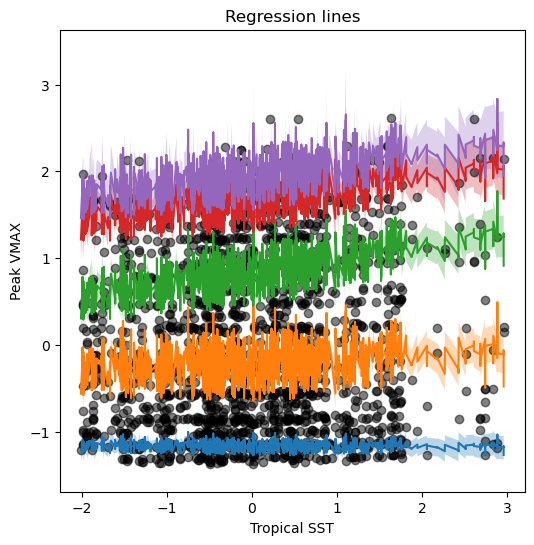

In [11]:
def plot_regression(x, y_mean, y_hpdi, ax):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    x_ordered = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]

    # Plot

    ax.plot(x_ordered, mean)

    ax.fill_between(x_ordered, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)

ci = 0.89
# Compute empirical posterior distribution over mu
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(dset.local_sst_scaled.values, dset.peak_wind_scaled.values, "ko", alpha=0.75)
ax.set(
    xlabel="Local SST", ylabel="Peak VMAX", title="Regression lines"
)
for q in qs:
    sample = params[q]
    # ## Bit misleading as it's not actually mu but let's just roll with it...
    # posterior_mu = jnp.expand_dims(sample["intercept"], -1)
    # + jnp.expand_dims(sample["local_coef"], -1) * dset.local_sst_scaled.values
    # + jnp.expand_dims(sample["tropical_coef"], -1) * dset.tropical_sst_scaled.values

    base_dims = ['chain','draw']
    mean_mu = sample.posterior_predictive['mu'].mean(dim=base_dims).values

    # Define the dimensions for the 'mu' and 'obs' variables that are not in the base dimensions
    mu_dims = [_ for _ in sample.posterior['mu'].coords.dims if not _ in base_dims]
    sim_dims = [_ for _ in sample.posterior_predictive['obs'].coords.dims if not _ in base_dims]
    
    # Calculate the HPDI for the 'mu' and 'obs' variables using the arviz.hdi() function
    hpdi_mu = az.hdi(
        sample.posterior, hdi_prob=ci, var_names=['mu']
    ).transpose('hdi',*mu_dims)['mu'].values
    hpdi_sim = az.hdi(
        sample.posterior_predictive, hdi_prob=ci, var_names=['obs']
    ).transpose('hdi',*sim_dims)['obs'].values

    plot_regression(dset.local_sst_scaled.values, mean_mu, hpdi_mu, ax)


plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(dset.tropical_sst_scaled.values, dset.peak_wind_scaled.values, "ko",alpha=0.5)
ax.set(
    xlabel="Tropical SST", ylabel="Peak VMAX", title="Regression lines"
);

for q in qs:
    sample = params[q]
    ## Bit misleading as it's not actually mu but let's just roll with it...
    base_dims = ['chain','draw']
    mean_mu = sample.posterior_predictive['mu'].mean(dim=base_dims).values

    # Define the dimensions for the 'mu' and 'obs' variables that are not in the base dimensions
    mu_dims = [_ for _ in sample.posterior['mu'].coords.dims if not _ in base_dims]
    sim_dims = [_ for _ in sample.posterior_predictive['obs'].coords.dims if not _ in base_dims]
    
    # Calculate the HPDI for the 'mu' and 'obs' variables using the arviz.hdi() function
    hpdi_mu = az.hdi(
        sample.posterior, hdi_prob=ci, var_names=['mu']
    ).transpose('hdi',*mu_dims)['mu'].values
    hpdi_sim = az.hdi(
        sample.posterior_predictive, hdi_prob=ci, var_names=['obs']
    ).transpose('hdi',*sim_dims)['obs'].values


    plot_regression(dset.tropical_sst_scaled.values, mean_mu, hpdi_mu, ax)


plt.show()
